In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:

!unzip /content/examples.zip -d /content/


Archive:  /content/examples.zip
replace /content/__MACOSX/._examples? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/__MACOSX/._examples  
replace /content/examples/01_h.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

First, let's make the appropriate imports. The leading library in processing is openCV, although the core itself, i.e. the vessel detection function (frangi), is located in the skimage library. Additionally, we use numpy to be able to modify images (matrices). To assess the quality of classification, we have used sklearn and imblearn. We used matplotlib to visualize the results. The wasp library will be helpful for loading images. The pandas library will only be useful for formatting classification results.

In [2]:
import cv2 as cv

import os
import pandas

from skimage.filters import frangi

import numpy as np

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.metrics import sensitivity_specificity_support, geometric_mean_score

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,8)

In [7]:
def plt_image(image: np.ndarray, title: str = '', cmap: str = 'gray'):
    plt.title(title)
    plt.axis('off')
    plt.imshow(image, cmap=cmap)

def normalize(image: np.ndarray, factor: float) -> np.ndarray:
    image = image * (factor / image.max())
    return image

In the next steps, we will present the approach used on the example of a selected image. We will then check the classification quality based on 5 randomly selected images. So let's load a sample image.

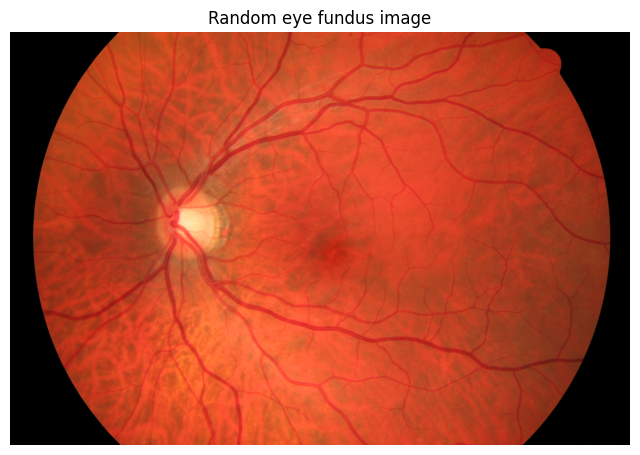

In [9]:
color_image = cv.imread('examples/02_h.jpg')
plt_image(cv.cvtColor(color_image, cv.COLOR_BGR2RGB), 'Random eye fundus image', None)

In order to further process the image of the fundus vessels, it is necessary to remove colors. The green channel will be the most useful, so we leave only this color in the image.

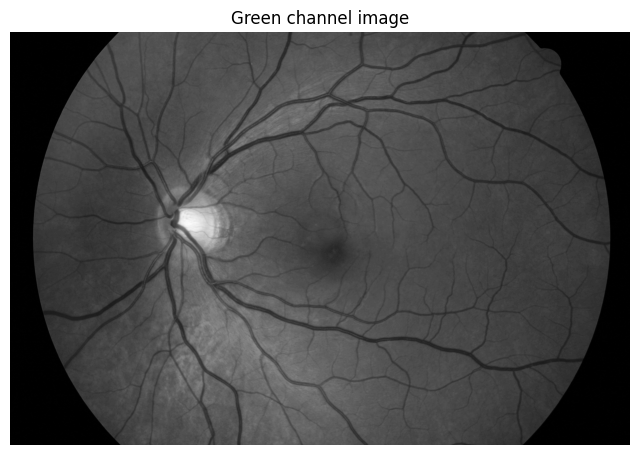

In [10]:
gray_image = color_image[:,:,1] # 0 - red, 1 - green , 2 - blue

plt_image(gray_image, 'Green channel image')

The vessels in the image above are quite well visible. However, the contrast can be further improved by using histogram equalization. For this, the equalizeHist() function can be used, but the adaptive method CLAHE provides much better results


In [ ]:
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
equalized = clahe.apply(gray_image)

plt_image(equalized, 'Histogram Equalization (CLAHE)')

Another important step is to remove noise from the image. One of the non-local means methods, specifically the fastNlMeansDenoising() function, works very well for this purpose. Unfortunately, selecting the parameters for this function is a kind of compromise between too much noise (non-vessels) and too few thin vessels.

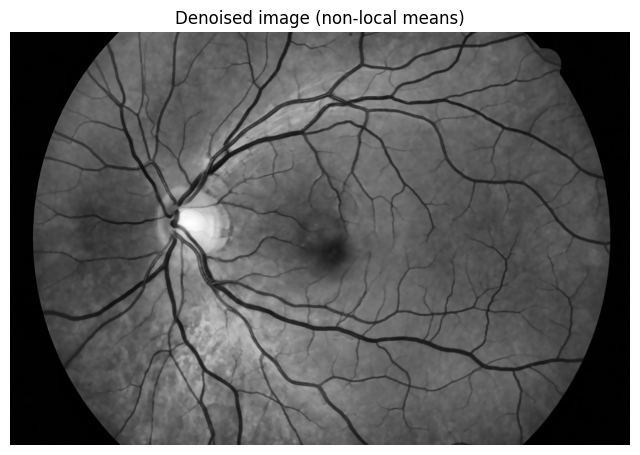

In [12]:
denoised = cv.fastNlMeansDenoising(equalized, None, 15)

plt_image(denoised, 'Denoised image (non-local means)')

At this stage, we can proceed to vessel detection. For this purpose, we will use the frangi() function, which was specifically created for this task. Additionally, we will normalize the image to values between 0 and 255

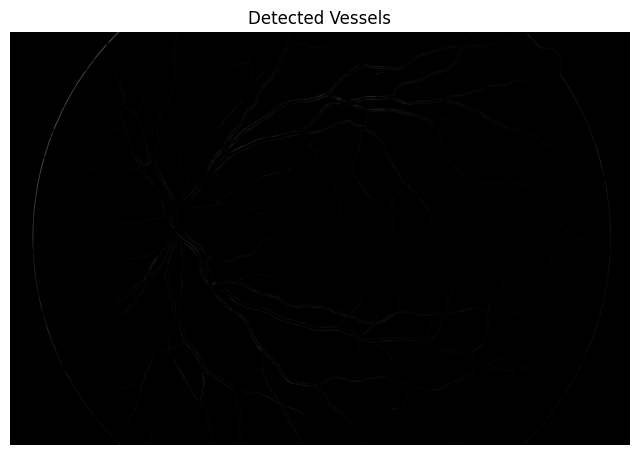

In [13]:
vessels = frangi(denoised)
vessels = normalize(vessels, 255).astype(np.uint8)

plt_image(vessels, 'Detected Vessels')


Now we can perform a very simple thresholding—let's consider everything that is not black as white.

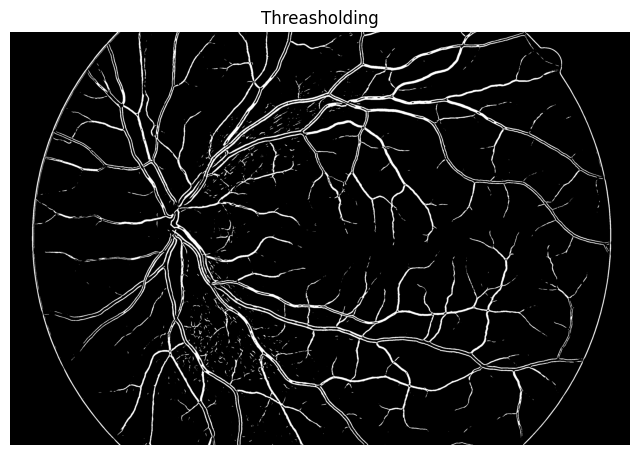

In [14]:
_, thresh = cv.threshold(vessels, 0, 255, cv.THRESH_BINARY)

plt_image(thresh, "Threasholding")

The next step involves removing small objects that remain in the image. This can be done using connectedComponentsWithStats

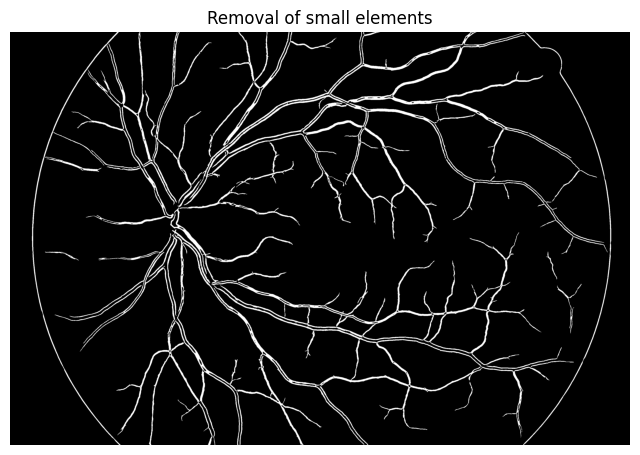

In [15]:
def remove_small_elements(image: np.ndarray, min_size: int) -> np.ndarray:
    components, output, stats, _ = cv.connectedComponentsWithStats(
        image, connectivity=8)

    sizes = stats[1:, -1]
    width = stats[1:, -3]
    height = stats[1:, -2]
    components -= 1

    result = np.zeros((output.shape))

    for i in range(0, components):
        if sizes[i] >= min_size and (width[i] > 150 or height[i] > 150):
            result[output == i + 1] = 255

    return result

small_removed = remove_small_elements(thresh, 800).astype(np.uint8)

plt_image(small_removed, 'Removal of small elements')

To remove extra noise, we are gonna use morphological transformations :
1. Dilation
2. Erosion

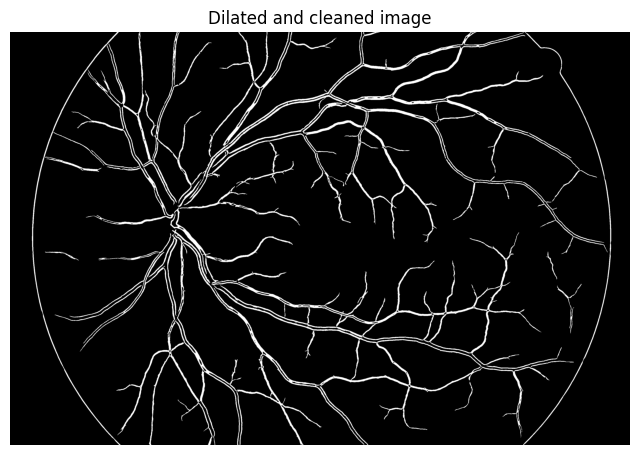

In [26]:
kernel_for_dilation = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))
kernel_for_erosion = cv.getStructuringElement(cv.MORPH_RECT, (4, 4))
dilated_image = cv.dilate(small_removed, kernel_for_dilation, iterations=1)
cleaned_image = cv.erode(dilated_image, kernel_for_erosion, iterations=1)
plt_image(small_removed,"Dilated and cleaned image")

Finally, we just need to remove the boundary of the eye. To do this, we will go back to the color image and prepare a mask based on it.

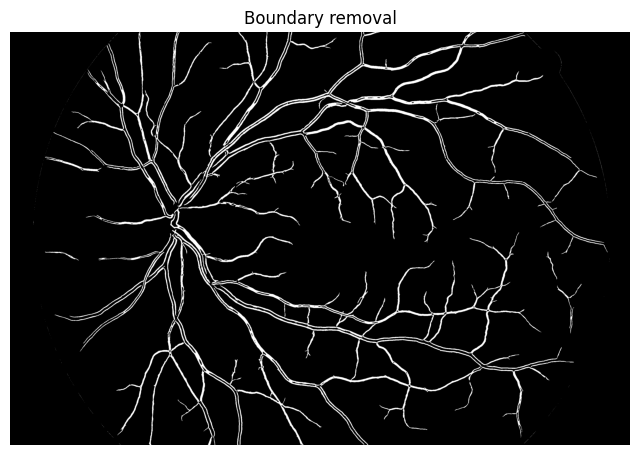

In [16]:
def remove_border(color_img: np.ndarray, image: np.ndarray) -> np.ndarray:
    hsv = cv.cvtColor(color_img, cv.COLOR_BGR2HSV)
    lower = np.array([0, 0, 80])
    upper = np.array([255, 255, 255])
    mask = cv.inRange(hsv, lower, upper)

    return cv.bitwise_and(image, mask)

end_result = remove_border(color_image, small_removed)
plt_image(end_result, 'Boundary removal')

**Ready Function**

Below is a ready-made function that performs the described processing. The function uses the implementations of normalize(), remove_small_elements(), and remove_border().

In [27]:
def process_input(path: str) -> np.ndarray:
    color_image = cv.imread(path)
    if color_image is None:
        raise FileNotFoundError(f'"{path}" not found')

    gray_image = color_image[:,:,1]

    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(gray_image)

    denoised = cv.fastNlMeansDenoising(equalized, None, 15)
    vessels = normalize(frangi(denoised), 255).astype(np.uint8)
    _, thresh = cv.threshold(vessels, 0, 255, cv.THRESH_BINARY)
    small_removed = remove_small_elements(thresh, 800).astype(np.uint8)
    end_result = remove_border(color_image, small_removed)

    return end_result

**Analysis of Approach Quality**

To compare the obtained results with the expert mask, let's create a function that displays selected classification metrics: accuracy, sensitivity, specificity, weighted sensitivity, weighted specificity, geometric mean, and confusion matrix.

In [18]:
# Helper function
def is_binary(image: np.ndarray) -> bool:
    return ((image == 0) | (image == 255)).all()

def compare(image: np.ndarray, truth: np.ndarray) -> dict:
    if not is_binary(image):
        raise Exception('Image is not binary (0 or 255)')

    if not is_binary(truth):
        raise Exception('Ground truth is not binary (0 or 255')

    image = image.flatten()
    truth = truth.flatten()

    report = classification_report(truth, image, output_dict=True)

    accuracy = round(accuracy_score(truth, image), 2)
    sensivity = round(report['255']['recall'], 2)
    specifity = round(report['0']['recall'], 2)

    weighted_result = sensitivity_specificity_support(
        truth, image, average='weighted')

    weight_sensivity = round(weighted_result[0], 2)
    weight_specifity = round(weighted_result[1], 2)
    matrix = confusion_matrix(truth, image)
    geometric_mean = round(geometric_mean_score(truth, image),2)

    return {
        'accuracy': accuracy,
        'sensivity': sensivity,
        'specifity': specifity,
        'wgt_sens': weight_sensivity,
        'wgt_spec': weight_specifity,
        'geo_mean': geometric_mean,
        'matrix': str(matrix.flatten())
    }


Additionally, it is worth visualizing the obtained vessels on the ground truth mask. We will do this by overlaying green pixels, which are considered vessels, onto the ground truth mask.

In [19]:
def visualise(image: np.ndarray, truth: np.ndarray) -> np.ndarray:
    predicted_vessels = (image == 255)
    true_vessels = (truth  == 255)

    predicted_correct = (predicted_vessels & true_vessels)

    green_predicted = np.zeros((*truth.shape, 3), dtype=np.uint8)
    green_predicted[true_vessels, :] = 255

    green_predicted[predicted_correct] = [0, 255, 0]

    return green_predicted

Analyse the images

In [20]:
def analyse(dir: str, out_dir: str):
    images = sorted(os.listdir(dir), key=lambda x: x.lower())  # Sort all images in the directory.

    if not os.path.isdir(out_dir):
        os.mkdir(out_dir)
        print(f'"{out_dir}" directory has been created.')

    if len(images) % 2 != 0:
        raise Exception("len(images) != len(ground_truth)")

    img = images[::2]
    truth = images[1::2]

    examples = [{'name': i, 'img': i, 'truth': t, 'comparison': None, 'visualisation': None}
                for i, t in zip(img, truth)]

    for example in examples:
        example['img'] = process_input(dir + example['img'])  # Process the input image.
        example['truth'] = cv.imread(dir + example['truth'], cv.IMREAD_GRAYSCALE)  # Load ground truth image.
        example['comparison'] = compare(example['img'], example['truth'])  # Compare images.
        example['visualisation'] = visualise(example['img'], example['truth'])  # visualizations.
        cv.imwrite(out_dir + example['name'][:-4] + ".jpg", example['img'])  # processed image.
        cv.imwrite(out_dir + example['name'][:-4] + "_w.jpg", example['visualisation'])

    fig, axs = plt.subplots(len(examples), 3, sharex=True, sharey=True)  # Create a subplot for each example.
    fig.set_figwidth(20)
    fig.set_figheight(6 * len(examples))

    axs = np.array([axs]) if len(examples) == 1 else axs

    for i, example in enumerate(examples):
        axs[i, 0].set_title('Ground truth Image', {'fontsize': 18})  #ground truth image.
        axs[i, 0].axis('off')
        axs[i, 0].imshow(example['truth'], cmap='gray')

        axs[i, 1].set_title('Processed ' + example['name'], {'fontsize': 18})  # processed input image.
        axs[i, 1].axis('off')
        axs[i, 1].imshow(example['img'], cmap='gray')

        axs[i, 2].set_title('Visualization', {'fontsize': 18})  #comparison visualization.
        axs[i, 2].axis('off')
        axs[i, 2].imshow(example['visualisation'], cmap='gray')

    plt.tight_layout()

    #comparison and confusion matrices for each image pair.
    index = [example['name'] for example in examples]
    matrix = [example['comparison'].pop('matrix', None) for example in examples]
    comparison = [example['comparison'] for example in examples]

    # DataFrame showing comparison results.
    print(pandas.DataFrame(comparison, index=index))
    print('------------------------------------------------------------------')
    # DataFrame showing confusion matrices.
    print(pandas.DataFrame(matrix, index=index, columns=['confusion_matrix']))


In [22]:
analyse('examples/', 'output/')

Output hidden; open in https://colab.research.google.com to view.

# Turtuosity

In [29]:
def calculate_tortuosity(vessel_coords: np.ndarray) -> float:
    if len(vessel_coords) < 2:
        return 0.0  # Avoid division by zero if there are not enough points

    #  path length
    path_length = 0.0
    for i in range(len(vessel_coords) - 1):
        distance = np.linalg.norm(vessel_coords[i] - vessel_coords[i + 1])
        path_length += distance

    #  straight line distance from the first to the last point
    straight_line_length = np.linalg.norm(vessel_coords[0] - vessel_coords[-1])

    # Tortuosity = Path Length / Straight Line Distance
    tortuosity = path_length / straight_line_length if straight_line_length > 0 else 0

    return tortuosity

In [30]:
def calculate_tortuosity_for_vessels(vessels: np.ndarray) -> dict:
    # Find contours of the vessels
    contours, _ = cv.findContours(vessels, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    tortuosities = {}

    for i, contour in enumerate(contours):
        # Get coordinates of the current vessel
        vessel_coords = contour[:, 0, :]  # Extract x, y coordinates
        tortuosity_value = calculate_tortuosity(vessel_coords)
        tortuosities[f'Vessel_{i}'] = tortuosity_value

    return tortuosities

In [31]:
vessels = process_input('examples/02_h.jpg')
tortuosities = calculate_tortuosity_for_vessels(vessels)

{'Vessel_0': 5.82842712474619, 'Vessel_1': 0.0, 'Vessel_2': 1.0, 'Vessel_3': 1.0, 'Vessel_4': 0.0, 'Vessel_5': 1.0, 'Vessel_6': 0.0, 'Vessel_7': 1.0, 'Vessel_8': 0.0, 'Vessel_9': 1.0, 'Vessel_10': 0.0, 'Vessel_11': 1.0, 'Vessel_12': 1.0, 'Vessel_13': 1.0, 'Vessel_14': 0.0, 'Vessel_15': 1.0, 'Vessel_16': 1.0, 'Vessel_17': 1.0, 'Vessel_18': 1.0, 'Vessel_19': 0.0, 'Vessel_20': 0.0, 'Vessel_21': 0.0, 'Vessel_22': 1.0, 'Vessel_23': 0.0, 'Vessel_24': 0.0, 'Vessel_25': 1.0, 'Vessel_26': 0.0, 'Vessel_27': 1.0, 'Vessel_28': 1.0, 'Vessel_29': 0.0, 'Vessel_30': 1.0, 'Vessel_31': 0.0, 'Vessel_32': 1.0, 'Vessel_33': 0.0, 'Vessel_34': 1.0, 'Vessel_35': 1.0, 'Vessel_36': 1.0, 'Vessel_37': 0.0, 'Vessel_38': 0.0, 'Vessel_39': 0.0, 'Vessel_40': 0.0, 'Vessel_41': 0.0, 'Vessel_42': 0.0, 'Vessel_43': 0.0, 'Vessel_44': 0.0, 'Vessel_45': 0.0, 'Vessel_46': 0.0, 'Vessel_47': 0.0, 'Vessel_48': 0.0, 'Vessel_49': 0.0, 'Vessel_50': 0.0, 'Vessel_51': 0.0, 'Vessel_52': 0.0, 'Vessel_53': 1.0, 'Vessel_54': 1.0, 'Vesse

In [32]:
for vessel, tortuosity in tortuosities.items():
    print(f'{vessel}: Tortuosity = {tortuosity}')

Vessel_0: Tortuosity = 5.82842712474619
Vessel_1: Tortuosity = 0.0
Vessel_2: Tortuosity = 1.0
Vessel_3: Tortuosity = 1.0
Vessel_4: Tortuosity = 0.0
Vessel_5: Tortuosity = 1.0
Vessel_6: Tortuosity = 0.0
Vessel_7: Tortuosity = 1.0
Vessel_8: Tortuosity = 0.0
Vessel_9: Tortuosity = 1.0
Vessel_10: Tortuosity = 0.0
Vessel_11: Tortuosity = 1.0
Vessel_12: Tortuosity = 1.0
Vessel_13: Tortuosity = 1.0
Vessel_14: Tortuosity = 0.0
Vessel_15: Tortuosity = 1.0
Vessel_16: Tortuosity = 1.0
Vessel_17: Tortuosity = 1.0
Vessel_18: Tortuosity = 1.0
Vessel_19: Tortuosity = 0.0
Vessel_20: Tortuosity = 0.0
Vessel_21: Tortuosity = 0.0
Vessel_22: Tortuosity = 1.0
Vessel_23: Tortuosity = 0.0
Vessel_24: Tortuosity = 0.0
Vessel_25: Tortuosity = 1.0
Vessel_26: Tortuosity = 0.0
Vessel_27: Tortuosity = 1.0
Vessel_28: Tortuosity = 1.0
Vessel_29: Tortuosity = 0.0
Vessel_30: Tortuosity = 1.0
Vessel_31: Tortuosity = 0.0
Vessel_32: Tortuosity = 1.0
Vessel_33: Tortuosity = 0.0
Vessel_34: Tortuosity = 1.0
Vessel_35: Tortuo

In [33]:
def evaluate_tortuosity(tortuosity_values: dict, threshold: float) -> dict:
    evaluation = {}
    for vessel, tortuosity in tortuosity_values.items():
        if tortuosity < threshold:
            evaluation[vessel] = "Normal"
        else:
            evaluation[vessel] = "Abnormal"
    return evaluation

In [34]:
threshold = 1.5 # should change later

In [44]:
evaluation_results = evaluate_tortuosity(tortuosities, threshold)
type(evaluation_results)
# for vessel, status in evaluation_results.items():
#     print(f'{vessel}: {status}')

dict

In [49]:
def visualize_tortuosity(image: np.ndarray, tortuosity_values: dict) -> np.ndarray:
    # Create a color image for visualization
    color_image = cv.cvtColor(image, cv.COLOR_GRAY2BGR)

    for vessel, tortuosity in tortuosity_values.items():

        contours, _ = cv.findContours(image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            if vessel in tortuosity_values:
                if tortuosity_values[vessel] < threshold:
                    color = (0, 255, 0)  # Green for normal
                else:
                    color = (0, 0, 255)  # Red for abnormal

                cv.drawContours(color_image, [contour], -1, color, 2)
    return color_image

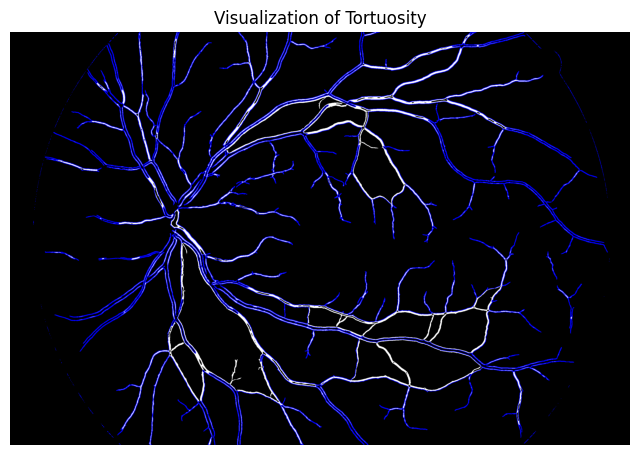

In [50]:
tortuosity_image = visualize_tortuosity(vessels, tortuosities)
plt_image(tortuosity_image, 'Visualization of Tortuosity')